<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare data</a></span><ul class="toc-item"><li><span><a href="#Tokenize-+-Padding" data-toc-modified-id="Tokenize-+-Padding-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Tokenize + Padding</a></span></li><li><span><a href="#One-hot-encoding-of-words-or-characters" data-toc-modified-id="One-hot-encoding-of-words-or-characters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>One-hot encoding of words or characters</a></span></li></ul></li><li><span><a href="#Define-model" data-toc-modified-id="Define-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define model</a></span></li><li><span><a href="#Create-dense-model" data-toc-modified-id="Create-dense-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create dense model</a></span></li><li><span><a href="#Create-dense-on-embedded-data" data-toc-modified-id="Create-dense-on-embedded-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create dense on embedded data</a></span></li><li><span><a href="#Create-lstm-model" data-toc-modified-id="Create-lstm-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create lstm model</a></span></li><li><span><a href="#CNN" data-toc-modified-id="CNN-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>CNN</a></span></li></ul></div>

## Dependencies

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals.joblib import Memory

from nltk.tokenize import RegexpTokenizer
import nltk
import pandas as pd
from nltk.corpus import stopwords
import FEATURE_SELECTOR_v4
import datetime
import json

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate
#from keras.utils.vis_utils import plot_model


In [2]:
memory = Memory(location='./tmp', verbose=0)

## Get data

In [3]:
#Path to data
path_data='.//datasets//constructed_2.csv'

df_texts=pd.read_csv(path_data,sep=',',header=0, index_col=0)
serie_texts=df_texts.text
serie_texts.size

11039

## Prepare data
We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:
* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).
<br><br>
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a Dense layer, capable of handling floating point vector data.

In [4]:


def prepare_data(serie_texts, labels, max_len=1000, test_size=0.33, random_state=42):
    sequences = tok.texts_to_sequences(serie_texts)
    sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
    X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, labels, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

### Tokenize + Padding

In [5]:

max_len=1000
test_size=0.33
max_words=1000

# The maximum number of words to keep, based on word frequency. Only the most common num_words words will be kept.
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(serie_texts)

In [6]:

X_train, X_test, y_train, y_test = prepare_data(serie_texts=serie_texts,max_len=max_len, labels=df_texts.label,test_size=test_size)

### One-hot encoding of words or characters

## Define model

In [7]:
def dense_model(data):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer=Dense(128, activation='relu')(inputs)
    layer = Dropout(0.2)(layer)
    layer=Dense(128, activation='relu')(layer)
    layer = Dropout(0.2)(layer)
    layer=Dense(1, activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [8]:
def embedding_flatten_model(data, max_words,embedding_units):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len)(inputs)
    layer = Flatten()(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model
    

In [9]:
def lstm_model(data, max_words,embedding_units=32 ,lstm_units=32, dense_units=256, dropout=0.2, recurrent_dropout=0.2):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len)(inputs)
    layer = LSTM(lstm_units,recurrent_dropout=recurrent_dropout)(layer)
    layer = Dense(dense_units,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(dropout)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [10]:
def cnn(data, max_words, embedding_units,conv_1_filter=32,conv_1_length=7, pooling_length= 5,conv_2_filter=32,conv_2_length=7):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len)(inputs)
    layer=Conv1D(conv_1_filter, conv_1_length, activation='relu')(layer)
    layer=MaxPooling1D(pooling_length)(layer)
    layer=Conv1D(conv_2_filter, conv_2_length, activation='relu')(layer)
    layer=GlobalMaxPooling1D()(layer)
    layer=Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model


In [11]:
def draw_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(1)
    plt.subplot(211)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    acc_values = acc
    val_acc_values = val_acc

    plt.subplot(212)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Create dense model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 144,769
Trainable params: 144,769
Non-trainable params: 0
_________________________________________________________________
Trai

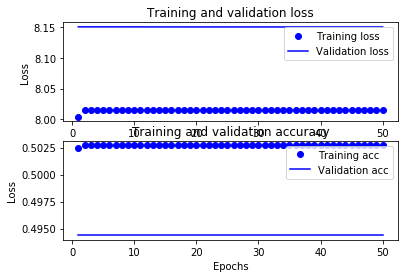

In [12]:
from keras import optimizers
from keras import losses
from keras import metrics

model_dense=dense_model(X_train)
model_dense.summary()
model_dense.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history=model_dense.fit(X_train,y_train,epochs=50,batch_size=126,validation_data=(X_test, y_test))
draw_history(history)

## Create dense on embedded data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 50)          50000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 50001     
Total params: 100,001
Trainable params: 100,001
Non-trainable params: 0
_________________________________________________________________
Train on 3698 samples, validate on 3698 samples
Epoch 1/4
3698/3698 [==============================] - 4s 1ms/step - loss: 0.6077 - acc: 0.6782 - val_loss: 0.6483 - val_acc: 0.6452
Epoch 2/4
3698/3698 [==============================] - 2s 592us/step - loss: 0.5378 - a

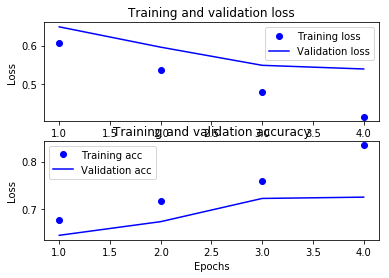

In [14]:
model_embedded_dense=embedding_flatten_model(X_train,max_words=max_words,embedding_units=50)
model_embedded_dense.summary()
model_embedded_dense.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history=model_embedded_dense.fit(X_train,y_train,epochs=4,batch_size=126,validation_split=0.5)#,validation_data=(X_test, y_test))
draw_history(history)

## Create lstm model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 50)          50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                10624     
_________________________________________________________________
FC1 (Dense)                  (None, 200)               6600      
_________________________________________________________________
activation_5 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 201       
__________

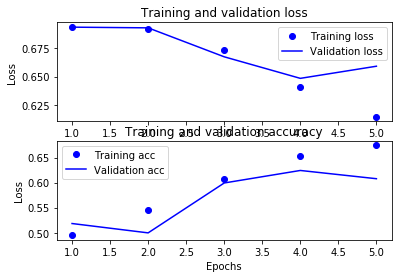

In [17]:
model=lstm_model(X_train, max_words=max_words, embedding_units=50 ,lstm_units=32, dense_units=200, dropout=0.2, recurrent_dropout=0.2)
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

history = model.fit(X_train,y_train,batch_size=500,epochs=5, validation_data=(X_test,y_test),callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

draw_history(history)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

print(X_train.shape,X_test.shape)
scaler=MinMaxScaler()
scaler.fit(np.concatenate((X_train,X_test), axis=0))
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
model.fit(X_train_scaled,y_train,batch_size=128,epochs=10,validation_split=0.0, validation_data=(X_test_scaled,y_test),callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

In [ ]:
model.fit(X_train,y_train,batch_size=128,epochs=10,validation_split=0.0, validation_data=(X_test,y_test),callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])model.fit(X_train,y_train,batch_size=128,epochs=10,validation_split=0.0, validation_data=(X_test,y_test),callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

## CNN

In [19]:
model_cnn=cnn(data=X_train, max_words=max_words, embedding_units=100, conv_1_filter=128,conv_1_length=9, pooling_length= 5,conv_2_filter=32,conv_2_length=9)
model_cnn.summary()

model_cnn.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model_cnn.fit(X_train, y_train,
                    epochs=10,
                    batch_size=500,
                    validation_split=0,validation_data=(X_test,y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 1000, 100)         100000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 992, 128)          115328    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 198, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 190, 32)           36896     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
__________

In [38]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
   
    return model

In [63]:
model_complex=define_model(length=max_len, vocab_size=max_words)
model_complex.summary()

 # compile
model_complex.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model_complex.summary())
#plot_model(model, show_shapes=True, to_file='multichannel.png')
history = model_complex.fit([X_train,X_train,X_train], np.array(y_train),
                    epochs=10,
                    batch_size=500,
                    validation_split=0,validation_data=(X_test,y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 1000, 100)    100000      input_49[0][0]                   
__________________________________________________________________________________________________
embedding_

TypeError: only integer scalar arrays can be converted to a scalar index

In [57]:
print(len([list(X_train),list(X_train),list(X_train)]))

3


In [52]:
print(len(np.array(X_train).reshape([7396,1000])))

7396


In [61]:
X_train.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'